# Dipolar Droplets: critical atom number study

<a href="https://colab.research.google.com/github/viktorcikojevic/dipolar-droplets/blob/main/critical_atom_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin

from tqdm import tqdm


# Functions for $n_c$ estimation

In [2]:
from estimate_nc.estimate_nc import estimate_nc, en_per_particle

## Physics parameters

In [3]:
a_s = 91.401702191
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 393.14   # https://www.wolframalpha.com/input?i=%28162+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 398 # https://www.wolframalpha.com/input?i=%28164+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# From Raul’s Thesis: m is the atomic mass, and Cdd = μ0 μ^2 sets the strength of the dipolar
# interaction, with μ = 9.93μB the magnetic dipole moment of 162Dy. We use dipolar units,
# obtained from the characteristic dipolar length r0 = m C_dd/ (4π \hbar^2) = 387.672168a0 and the
# dipolar scale of energy 0 = ~2
# 

## Test the $N_c$ function

In [4]:
# These are the MF+LHY estimations from IGOR. Let's try to reproduce some of these
!cat experimental-data/mean_field_IGOR.dat  

#a	N
60.5970075184  550.962558145
62.7356641274  630.484693517
64.8743207365  721.484505403
66.7271283591  798.254461363
68.8657849681  913.469004347
70.8615170839  1027.84403302
72.7158135034  1176.19595118
74.853725714  1323.46689853
76.9931267214  1540.22653908
78.9896032357  1762.532214
80.5587950671  1983.2180518
82.6974516761  2269.46206612
84.5532368924  2686.04636111
87.4057715689  3288.07864054
89.4044812784  3957.78164425
91.401702191  4605.99379639
93.9721098732  5930.74447925
96.3988486638  7383.40961091
98.2561226769  9038.277145
99.8275477035  10697.3506182



In [5]:

a_s = 91.401702191
a_s = a_s / r_0
alpha = 2*np.pi*a_s # * (1 - 1 / (3*(a_s / r_0)))
beta = 256*np.sqrt(np.pi)*a_s**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt(a_s)/45
gamma = 1.5

n_c_best_possible_fit, min_energy = estimate_nc(alpha, beta, gamma, include_ho=False, based_on='size')
n_c_best_possible_fit, min_energy

(6014.672060418236, 9.972961264054853e-06)

In [6]:
ng = 400
sr_range = np.linspace(4, 100, ng)
sz_range = np.linspace(4, 1000, ng)
# make meshgrid
sr, sz = np.meshgrid(sr_range, sz_range)
nparticles = 100

np.min(en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False))

4.994387305328081e-05

In [7]:
# r_0 = 360.375
a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]

# Recipe: Fit the $E_{\rm kin}/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: Use $\beta\rho^\gamma$ instead of the LHY term



a_s = 110.0, popt[alpha,beta,gamma]=[0.11883386 3.28002707 1.52530296]


a_s = 101.572, popt[alpha,beta,gamma]=[0.22125296 3.19806864 1.59521284]


a_s = 90.0, popt[alpha,beta,gamma]=[-0.04210235  2.23638411  1.35239522]


a_s = 80.0, popt[alpha,beta,gamma]=[0.27080808 2.38773349 1.56886656]


a_s = 70.0, popt[alpha,beta,gamma]=[0.38361545 2.23528507 1.663546  ]


a_s = 60.0, popt[alpha,beta,gamma]=[0.48306191 2.22129791 1.79371164]


(0.0, 0.21837499999999999)

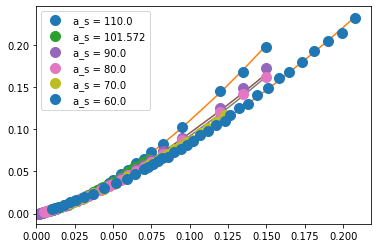

In [8]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    kin_en = data[:, 3]
    sen_kin = data[:, 4]
    
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    
    
    plt.errorbar(rho_all, kin_en, sen_kin, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , kin_en,sigma=sen_kin, maxfev=10000)
    
    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt}")
    # sort rho_all
    idx = np.argsort(rho_all)
    rho_all = rho_all[idx]
    plt.plot(rho_all, enFit(rho_all, *popt))
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Estimate $n_c$

In [ ]:
a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/dy-df
fout = open(f"results/dy-df/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
# Write the first line, which is the header: string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
string_out = f"# a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  \n"
fout.write(string_out)
for rho_min_x in tqdm(np.arange(0.4, 0.81, 0.1)):
  for rho_max_x in np.arange(1.5, 2.91, 0.2):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        # # print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        # # print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        kin_en = data[:,3]
        sen_kin = data[:,4]        

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = kin_en[w]
        sen_all_w = sen_kin[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, p0=[-1, 5, 1.5], maxfev=10000)
            alpha, beta, gamma = popt
            alpha = alpha_mf
            n_c_best_possible_fit, min_energy = estimate_nc(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_nc(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_nc(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_nc(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
            fout.write(string_out)
            # # print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))